# Training LSTM on *all flight paths* that intersect Chicgo airspace

* 'adsb_Chicago_flights.csv' contains 57 flight paths, with 11,697 observations (including nans) within a 1 hour window 
    * issues: Non-Unique index when using time variable to index and based on preliminary research we should index the data by TIME 
        * Solution: istead if indexing by time, I have reordered the entire dataset by flight path (icao24) then by time, so the order the data is feed into the LSTM matters. 
    * cannot load string/text based based onto LSTM (must convert to nuerical categorical variable)
        * Solution: convert string categoriacl variabel to numerical categorical variable
* please see LSTM_a19835.ipynb file for intial and individual flight training results

In [1]:
#importing necessary packages
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.metrics
import math
import time

### Data Preprocessing
* cleaning data of nans
* reclassifying categorical variable to numerical categories
* splitting data into independent (x) and dependent (y) variables

In [2]:
#reading and inspecting the data for 57 flights intersecting Chicago airspace called 'adsb_Chicago_flights'
df = pd.read_csv('Flight_Data/adsb_Chicago_flights.csv', index_col = 'OBJECTID', parse_dates = True) 
#change the index column so they are unique (need not be time so ong as order is preserved!)

#intial inspection
print(len(df), df.info())
df.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11697 entries, 1 to 11697
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   time           11697 non-null  int64  
 1   icao24         11697 non-null  object 
 2   lat            11697 non-null  float64
 3   lon            11697 non-null  float64
 4   velocity       10651 non-null  float64
 5   heading        10651 non-null  float64
 6   vertrate       10651 non-null  float64
 7   callsign       11628 non-null  object 
 8   onground       11697 non-null  bool   
 9   alert          11697 non-null  bool   
 10  spi            11697 non-null  bool   
 11  squawk         11236 non-null  float64
 12  baroaltitude   10606 non-null  float64
 13  geoaltitude    10280 non-null  float64
 14  lastposupdate  11697 non-null  float64
 15  lastcontact    11697 non-null  float64
dtypes: bool(3), float64(10), int64(1), object(2)
memory usage: 1.3+ MB
11697 None


,time,icao24,lat,lon,velocity,heading,vertrate,callsign,onground,alert,spi,squawk,baroaltitude,geoaltitude,lastposupdate,lastcontact
OBJECTID,,,,,,,,,,,,,,,,
1,1590364810,abef2f,41.504160,-88.314940,139.650465,63.529340,0.32512,SWA6893,False,False,False,1210.0,1539.24,1569.72,1.590365e+09,1.590365e+09
2,1590364810,a23d25,39.759064,-87.232460,228.154609,2.714021,0.00000,SWA399,False,False,False,3163.0,12192.00,12649.20,1.590365e+09,1.590365e+09
3,1590364810,abdd09,40.745865,-82.465942,209.393875,287.589152,-0.32512,SWA163,False,False,False,7542.0,12184.38,12633.96,1.590365e+09,1.590365e+09


In [3]:
# REPLACING ALL NAN values in my altitude column for 0 (becasue it is on the ground they no longer report the alt)
#a necessary step if I hope to predict altitude (LSTM doesn't work with nan)
df['geoaltitude'] = df['geoaltitude'].fillna(0)
df['velocity'] = df['velocity'].fillna(0)
df['vertrate'] = df['vertrate'].fillna(0)
df = df.dropna(subset=['heading'])
#inspect data to make sure it worked
#df.tail(5)

### Preprocessing, creating new numerical variable from categorical icao24 data

The icao24 column needs to be converted to a numerical category column, the following code cell converts the string to numerical categories

In [4]:
#converts ALL our string cols to numerical categories
def handle_non_numerical_data(db):
    columns = db.columns.values
    for column in columns:
        text_digit_vals = {}
        def convert_to_int(val):
            return text_digit_vals[val]

        if db[column].dtype != np.int64 and db[column].dtype != np.float64:
            column_contents = db[column].values.tolist()
            unique_elements = set(column_contents)
            h = 0
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = h
                    h+=1

            db[column] = list(map(convert_to_int, db[column]))

    return db

#sourced code from https://pythonprogramming.net/working-with-non-numerical-data-machine-learning-tutorial/

df= handle_non_numerical_data(df)
df.head()

,time,icao24,lat,lon,velocity,heading,vertrate,callsign,onground,alert,spi,squawk,baroaltitude,geoaltitude,lastposupdate,lastcontact
OBJECTID,,,,,,,,,,,,,,,,
1,1590364810,52,41.504160,-88.314940,139.650465,63.529340,0.32512,7,0,0,0,1210.0,1539.24,1569.72,1.590365e+09,1.590365e+09
2,1590364810,36,39.759064,-87.232460,228.154609,2.714021,0.00000,46,0,0,0,3163.0,12192.00,12649.20,1.590365e+09,1.590365e+09
3,1590364810,7,40.745865,-82.465942,209.393875,287.589152,-0.32512,20,0,0,0,7542.0,12184.38,12633.96,1.590365e+09,1.590365e+09
4,1590364810,14,42.897125,-87.849043,134.041047,219.861881,25.68448,52,0,0,0,4326.0,1905.00,1935.48,1.590365e+09,1.590365e+09
5,1590364810,54,41.815430,-87.811473,131.682592,249.653541,14.30528,1,0,0,0,6555.0,1485.90,1493.52,1.590365e+09,1.590365e+09


## Exploring my ability to reorder the csv
i can sort my df based on two cols (first the icao , then the time), since LSTMs work for sequential data and preserve order!

In [5]:
#reordering my dataset
df = df.sort_values(by = ['icao24','time'])
df

,time,icao24,lat,lon,velocity,heading,vertrate,callsign,onground,alert,spi,squawk,baroaltitude,geoaltitude,lastposupdate,lastcontact
OBJECTID,,,,,,,,,,,,,,,,
7003,1590367040,0,41.783985,-87.753424,54.939633,43.861823,-0.32512,6,0,0,0,6542.0,205.74,152.40,1.590367e+09,1.590367e+09
7046,1590367050,0,41.788467,-87.747740,67.321440,43.451842,0.32512,6,0,0,0,6542.0,220.98,160.02,1.590367e+09,1.590367e+09
7069,1590367060,0,41.792877,-87.742182,80.058462,43.437775,13.00480,6,0,0,0,6542.0,365.76,304.80,1.590367e+09,1.590367e+09
7112,1590367070,0,41.797668,-87.734320,83.424038,66.755016,13.65504,6,0,0,0,6542.0,480.06,441.96,1.590367e+09,1.590367e+09
7140,1590367080,0,41.799673,-87.725638,84.852076,79.166954,11.05408,6,0,0,0,6542.0,609.60,586.74,1.590367e+09,1.590367e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11540,1590368350,56,42.897629,-89.022408,73.845565,315.282243,0.00000,18,0,0,0,4307.0,1379.22,1379.22,1.590368e+09,1.590368e+09
11550,1590368360,56,42.902390,-89.028732,74.265475,317.245743,0.00000,18,0,0,0,4307.0,1379.22,1379.22,1.590368e+09,1.590368e+09
11598,1590368370,56,42.907425,-89.034928,73.917207,317.538545,0.00000,18,0,0,0,4307.0,1379.22,1379.22,1.590368e+09,1.590368e+09


### choosing x and y variables (predictor and predicted variables)

In [6]:
# x retains all the data used to prdict y... (velocity, heading, vertrate, latposupd, and lastcontact)
x_vars = ['time', 'icao24', 'velocity', 'heading', 'vertrate', 'lastposupdate', 'lastcontact']
x = df[x_vars]
# y are both the lat and lon columns (later try and predict alt as well...)
y_vars = ['time', 'icao24', 'lon', 'lat']
y =df[y_vars]

print(np.min(x['icao24']), np.max(x['icao24']))#should have a range of 57 flight path categories
x

0 56


,time,icao24,velocity,heading,vertrate,lastposupdate,lastcontact
OBJECTID,,,,,,,
7003,1590367040,0,54.939633,43.861823,-0.32512,1.590367e+09,1.590367e+09
7046,1590367050,0,67.321440,43.451842,0.32512,1.590367e+09,1.590367e+09
7069,1590367060,0,80.058462,43.437775,13.00480,1.590367e+09,1.590367e+09
7112,1590367070,0,83.424038,66.755016,13.65504,1.590367e+09,1.590367e+09
7140,1590367080,0,84.852076,79.166954,11.05408,1.590367e+09,1.590367e+09
...,...,...,...,...,...,...,...
11540,1590368350,56,73.845565,315.282243,0.00000,1.590368e+09,1.590368e+09
11550,1590368360,56,74.265475,317.245743,0.00000,1.590368e+09,1.590368e+09
11598,1590368370,56,73.917207,317.538545,0.00000,1.590368e+09,1.590368e+09


In [7]:
#a little supicious of the fact my icao24 column ends with 9, instead of the 56th categroy (which i suume would be the largest and thus last value in df)
print(np.min(df['icao24']), np.max(df['icao24']))

0 56


In [8]:
#a look at my current x or y data (and my desired variables)
y.head()

,time,icao24,lon,lat
OBJECTID,,,,
7003,1590367040,0,-87.753424,41.783985
7046,1590367050,0,-87.747740,41.788467
7069,1590367060,0,-87.742182,41.792877
7112,1590367070,0,-87.734320,41.797668
7140,1590367080,0,-87.725638,41.799673


### seperate each flight path into its own dataframe

This step results in a list of dataframes wihc are erperated by flight paths, I will be able to divide the data into test and train datasets based one the time threshold of  1590368080 (90% of the first hour of observations in my data. As a results of dividing the test and train subests by time, there are some fligh paths with no test datapoints (they end before the 56 minute mark). 

In [9]:
#let's seperate my current csv 'adsb_Chicago_flights' by flight path (aka icao24 variable)
x_s = [m for _, m in x.groupby('icao24')]
x_s

y_s = [m for _, m in y.groupby('icao24')]
#y_s

[                time  icao24        lon        lat
 OBJECTID                                          
 7003      1590367040       0 -87.753424  41.783985
 7046      1590367050       0 -87.747740  41.788467
 7069      1590367060       0 -87.742182  41.792877
 7112      1590367070       0 -87.734320  41.797668
 7140      1590367080       0 -87.725638  41.799673
 ...              ...     ...        ...        ...
 11547     1590368350       0 -84.608843  42.098678
 11564     1590368360       0 -84.582080  42.101285
 11595     1590368370       0 -84.555525  42.103912
 11630     1590368380       0 -84.529128  42.106453
 11693     1590368390       0 -84.501905  42.109131
 
 [136 rows x 4 columns],
                 time  icao24        lon        lat
 OBJECTID                                          
 1281      1590365230       1 -87.754318  41.783147
 1295      1590365240       1 -87.748989  41.787369
 1332      1590365250       1 -87.743204  41.791946
 1357      1590365260       1 -87.739

In [10]:
print(len(x_s), type(x_s))#great it has 57 seperate DataFrames that i can now use to train my LSTM
print(len(y_s), type(y_s))
y_s[0] #returns dataframe for icao24 == 0 == 4bb145 ( i actually can't confirm 0 == 4bb145)

57 <class 'list'>
57 <class 'list'>


,time,icao24,lon,lat
OBJECTID,,,,
7003,1590367040,0,-87.753424,41.783985
7046,1590367050,0,-87.747740,41.788467
7069,1590367060,0,-87.742182,41.792877
7112,1590367070,0,-87.734320,41.797668
7140,1590367080,0,-87.725638,41.799673
...,...,...,...,...
11547,1590368350,0,-84.608843,42.098678
11564,1590368360,0,-84.582080,42.101285
11595,1590368370,0,-84.555525,42.103912


In [11]:
#I have a list of dataframes, i need to dropna and icao24 variable from each since i no longer need it
def DropnaValues(list_of_dataframes):
    for index,dataframe in enumerate(list_of_dataframes):
        #pass
        #print(dataframe)
        list_of_dataframes[index] = list_of_dataframes[index].dropna() #issue, i need to drop nan values before seperateing y and x....

    return list_of_dataframes

nax_s = DropnaValues(x_s)
nax_s

nay_s = DropnaValues(y_s)
nay_s
#random sample (looking at 8th datframe length)
print(len(nax_s[1]), len(nay_s[1]))
#print(len(x_s[0].dropna()))

#this for looop doesn't do what i want it to do yet....

317 317


In [12]:
#a quick look at the data thus far
x_s[14] #seems my for loop worked...


,time,icao24,velocity,heading,vertrate,lastposupdate,lastcontact
OBJECTID,,,,,,,
4,1590364810,14,134.041047,219.861881,25.68448,1.590365e+09,1.590365e+09
42,1590364820,14,135.704048,220.695531,24.70912,1.590365e+09,1.590365e+09
61,1590364830,14,137.659678,222.273689,21.45792,1.590365e+09,1.590365e+09
81,1590364840,14,139.052224,222.901094,17.88160,1.590365e+09,1.590365e+09
118,1590364850,14,140.130051,223.066072,14.63040,1.590365e+09,1.590365e+09
...,...,...,...,...,...,...,...
3973,1590366060,14,64.307558,89.541644,-3.57632,1.590366e+09,1.590366e+09
3988,1590366070,14,64.307558,89.541644,-3.57632,1.590366e+09,1.590366e+09
4018,1590366080,14,64.307558,89.541644,-3.57632,1.590366e+09,1.590366e+09


## spliting the data into 2 parts (train and test)

need to perform this step before i rescale my data.

Choose arbitary threshold (train with 90% of data, which is the first 54mins of my data...this leaves 6 mins worth of point data for testing)
The first 54mins for training, and last 6 mins for testing. 


In [13]:
#subsetting the data based time (another flight obeservations before 1590368080 will be used as training data
#not all flight paths have observations beyond the 1590368080 time 

def Spliting_test_train(list_x_dataframes, list_y_dataframes):
    test_x = []
    test_y = []
    train_x =[]
    train_y =[]
    for index,dataframe in enumerate(list_x_dataframes):
        Test_datax = list_x_dataframes[index][list_x_dataframes[index]['time'] >= 1590368080]
        test_x.append(Test_datax)
        Train_datax = list_x_dataframes[index][list_x_dataframes[index]['time'] < 1590368080]
        train_x.append(Train_datax)
        Test_datay = list_y_dataframes[index][list_y_dataframes[index]['time'] >= 1590368080]
        test_y.append(Test_datay)
        Train_datay = list_y_dataframes[index][list_y_dataframes[index]['time'] < 1590368080]
        train_y.append(Train_datay)
    #print(len(x_s[2]), len(Train_data), len(Test_data))
    
    return test_x, test_y, train_x, train_y

x_test ,y_test, x_train,y_train = Spliting_test_train(x_s, y_s)

# print("Training Shape", x_train.shape, y_train.shape)
# print("Testing Shape", x_test.shape, y_test.shape) 

In [14]:
#tells me how many test dataframes have observations we can use within our testing (it appears we have 20 icao (flight paths) with no test data (due to lack of observations past time threshold
for i,e in enumerate(x_test):
    print(len(x_test[i]))

32
32
0
32
0
32
0
32
16
32
32
0
32
0
0
0
32
32
32
27
0
0
0
32
32
32
0
32
32
32
32
32
0
32
32
32
0
32
0
0
32
32
0
0
0
32
32
32
32
32
32
0
0
8
32
32
32


In [16]:
#a look at the length fo dataframes for our test flight paths (large variation 0 to 327 time observations)
for i,e in enumerate(x_train):
    print(len(x_train[i]))

104
285
271
136
53
327
45
327
0
262
269
99
88
228
130
69
80
292
148
0
39
130
136
319
119
327
105
74
327
324
255
87
153
104
27
267
220
51
136
112
111
309
172
224
319
310
8
54
17
24
278
251
95
0
327
315
173


## remerge seperate dataframes into one dataframe (ordered by icao categroy then time)

currently have 4 dataframes (made of lists for 57 dataframes), i want to keeo these dataframes seperate, but make each one dataframe instead of 57 within a list.


In [17]:
#dataframes must have the same column names
def remerge_df(list_of_dataframes):
    df_list = []
    for index,dataframe in enumerate(list_of_dataframes):
        df_list.append(list_of_dataframes[index])
    #print(df_list)
    #appends dataframes  (increasing number of rows)
    merged = pd.concat(df_list)
    return merged

x_test_ = remerge_df(x_test)
y_test_ = remerge_df(y_test)
x_train_ = remerge_df(x_train)
y_train_ = remerge_df(y_train)

print(len(x_test_), len(x_train_))

1139 9512


In [18]:
#successfully remerged let's look at the data quick:
x_test_ #currently looks ordered by icao24 and time, but let's make sure

#great news, the reodereding of the data at the begninig of this doc (by icao then time) is PRESERVED! 

,time,icao24,velocity,heading,vertrate,lastposupdate,lastcontact
OBJECTID,,,,,,,
10522,1590368080,0,225.901844,82.146687,0.0,1.590368e+09,1.590368e+09
10577,1590368090,0,225.972711,82.017472,0.0,1.590368e+09,1.590368e+09
10621,1590368100,0,225.972711,82.017472,0.0,1.590368e+09,1.590368e+09
10642,1590368110,0,225.972711,82.017472,0.0,1.590368e+09,1.590368e+09
10668,1590368120,0,225.901844,82.146687,0.0,1.590368e+09,1.590368e+09
...,...,...,...,...,...,...,...
11540,1590368350,56,73.845565,315.282243,0.0,1.590368e+09,1.590368e+09
11550,1590368360,56,74.265475,317.245743,0.0,1.590368e+09,1.590368e+09
11598,1590368370,56,73.917207,317.538545,0.0,1.590368e+09,1.590368e+09


In [19]:
y_train_

,time,icao24,lon,lat
OBJECTID,,,,
7003,1590367040,0,-87.753424,41.783985
7046,1590367050,0,-87.747740,41.788467
7069,1590367060,0,-87.742182,41.792877
7112,1590367070,0,-87.734320,41.797668
7140,1590367080,0,-87.725638,41.799673
...,...,...,...,...
10351,1590368030,56,-88.828520,42.740570
10401,1590368040,56,-88.833639,42.745926
10440,1590368050,56,-88.839257,42.751465


In [20]:
#now, need to drop unnesscary columns, KEEP icao24 (see if this variable imporves the prediction
def DropCol_y(dataframes):
    dataframes = dataframes.drop("time", axis=1)
    dataframes = dataframes.drop("icao24", axis=1)
    return dataframes
def DropCol_x(dataframes):
    dataframes = dataframes.drop("time", axis=1)
    return dataframes
x_test_ = DropCol_x(x_test_)
x_test_

y_test_ = DropCol_y(y_test_)
y_test_

x_train_ = DropCol_x(x_train_)
x_train_

y_train_ = DropCol_y(y_train_)
y_train_

,lon,lat
OBJECTID,,
7003,-87.753424,41.783985
7046,-87.747740,41.788467
7069,-87.742182,41.792877
7112,-87.734320,41.797668
7140,-87.725638,41.799673
...,...,...
10351,-88.828520,42.740570
10401,-88.833639,42.745926
10440,-88.839257,42.751465


In [21]:
x_train_#keeping the icao24 variable for training...

,icao24,velocity,heading,vertrate,lastposupdate,lastcontact
OBJECTID,,,,,,
7003,0,54.939633,43.861823,-0.32512,1.590367e+09,1.590367e+09
7046,0,67.321440,43.451842,0.32512,1.590367e+09,1.590367e+09
7069,0,80.058462,43.437775,13.00480,1.590367e+09,1.590367e+09
7112,0,83.424038,66.755016,13.65504,1.590367e+09,1.590367e+09
7140,0,84.852076,79.166954,11.05408,1.590367e+09,1.590367e+09
...,...,...,...,...,...,...
10351,56,74.217351,324.877836,0.32512,1.590368e+09,1.590368e+09
10401,56,74.096011,324.323592,0.00000,1.590368e+09,1.590368e+09
10440,56,74.087081,322.334379,0.00000,1.590368e+09,1.590368e+09


### Rescaling

In [22]:
# rescaling all of my data....(based on the tutorial) y-> MinMax and x -> standard
#mm used to scale values between 0-1

def Rescale_list_data(x_dataframes, y_dataframes):
    x_ss =[]
    y_mm =[]
    mm = MinMaxScaler()
    ss = StandardScaler()
    
    if len(x_dataframes) ==0: 
        x_ss.append(x_dataframes)
    if len(y_dataframes) ==0:
        y_mm.append(y_dataframes)
    else: 
        rescaled_x = ss.fit_transform(x_dataframes)
        x_ss.append(rescaled_x)
        rescaled_y = mm.fit_transform(y_dataframes)
        y_mm.append(rescaled_y)
    
    return x_ss, y_mm

n_x_train, n_y_train = Rescale_list_data(x_train_, y_train_)
n_x_test, n_y_test = Rescale_list_data(x_test_, y_test_)

print(len(n_x_train[0]), len(n_y_train[0]), len(n_x_test[0]), len(n_y_test[0]))

9512 9512 1139 1139


### convert our numpy to tensors

In [23]:

def NUM_Ten(x_dataframes, y_dataframes):
    x_tensors = torch.Tensor(x_dataframes)
    y_tensors = Variable(torch.Tensor(y_dataframes))
    
    return x_tensors, y_tensors

x_train_tensors, y_train_tensors = NUM_Ten(n_x_train, n_y_train)
x_test_tensors, y_test_tensors = NUM_Ten(n_x_test, n_y_test)

print(len(x_train_tensors[0][0]), type(x_train_tensors[0]))

6 <class 'torch.Tensor'>


C:\Users\runac\miniconda3\envs\geog3531\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  


In [24]:
x_train_tensors[0].shape[0]

9512

### adding another dimension to tensors, for time

In [25]:
#import format for lSTMs needs to have each TIMESTAMP
#reshaping to rows, timestamps, features

def AddingDim(x_dataframes): 
    x_train_tensors_final_ = torch.reshape(x_dataframes, (x_dataframes[0].shape[0], 1, x_dataframes[0].shape[1]))
     #x_train_tensors_final = torch.reshape(x_train_tensors,   (x_train_tensors.shape[0], 1, x_train_tensors.shape[1]))
    return x_train_tensors_final_


x_train_tensors_final = AddingDim(x_train_tensors)
x_test_tensors_final = AddingDim(x_test_tensors)

print("Training Shape", x_train_tensors_final.shape, y_train_tensors[0].shape)
print("Testing Shape", x_test_tensors_final.shape, y_test_tensors[0].shape)


Training Shape torch.Size([9512, 1, 6]) torch.Size([9512, 2])
Testing Shape torch.Size([1139, 1, 6]) torch.Size([1139, 2])


### Building the LSTM

based entirely on the demo

In [26]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes (number of output variables)
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size  (number of input variables)
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    #pass in input a t time t
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out
    
    

In [27]:
# defining some input variables

#frist 2 variables aren't part of the defined input parameter?? when are they used?- Later when we train the lstm
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 6 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 2 #number of output classes

lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, x_train_tensors_final.shape[1])
lstm1

LSTM1(
  (lstm): LSTM(6, 2, batch_first=True)
  (fc_1): Linear(in_features=2, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
)

In [35]:
start = time.process_time() #i suspect this will take some time...Let's see how long it actually takes


def RepeatedLSTMtraining(list_x_train_tensors, list_y_train_tensors, model, PATH):
    #defining our loss function and optimizer...
    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

    # now we will loop over each epoch, calculate a loss, and imporve weights via the optimizer
    for epoch in range(num_epochs):
        outputs = model.forward(list_x_train_tensors) #forward pass
        optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
      # obtain the loss function
        loss = criterion(outputs, list_y_train_tensors)
     
        loss.backward() #calculates the loss of the loss function
 
        optimizer.step() #improve from loss, i.e backprop
        if epoch % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) #how can i improve the LSTM if it cannot caulate the loss
        
        #WHY is Loss NAN?--must train LSTM one flight path at a time (seperate csv files for each flight path?)

    torch.save(model.state_dict(), PATH)      

# saved first model based on one flight    
RepeatedLSTMtraining(x_train_tensors_final, y_train_tensors[0], lstm1, "Saved_LSTM_Models/allflights.pt")

#reloading previous model to train with more flight data...
#= RepeatedLSTMtraining(x_train_tensors_final[1], y_train_tensors[1], lstm1, "Saved_LSTM_Models/flight1.pt")
# flight2 = RepeatedLSTMtraining(x_train_tensors_final[2], y_train_tensors[2], lstm1, flight2)
# flight3 = RepeatedLSTMtraining(x_train_tensors_final[3], y_train_tensors[3], lstm1, flight3)
# flight4 = RepeatedLSTMtraining(x_train_tensors_final[4], y_train_tensors[4], lstm1, flight4)

print('Time', time.process_time() - start)

Epoch: 0, loss: 0.01157
Epoch: 100, loss: 0.01093
Epoch: 200, loss: 0.01036
Epoch: 300, loss: 0.00998
Epoch: 400, loss: 0.00970
Epoch: 500, loss: 0.00943
Epoch: 600, loss: 0.00919
Epoch: 700, loss: 0.00874
Epoch: 800, loss: 0.00829
Epoch: 900, loss: 0.00805
Time 30.515625


Succesfully trained LSTM on all flight data borfore the time threshold ' 1590368080'.

This document has been dealing with handling all 57 flight paths around the Chicago Arispace, and resulted in stacked dataframes within a list serperated by differnt flight paths. By indexing the list based on icao category then time, i have fed in a ordered sequnce of flight path observations. 
I have a sneaking supiscion training with more data will introduce more error (since my range for lat and lon has increased based on the current obersvations. 

### Now that i have trained the model, i need to look at how it performs when given test data...

In [36]:
#reloading my original dataframe to use the original values from the data for my testing of my trained LSTM
df1 = pd.read_csv('Flight_Data/adsb_Chicago_flights.csv', index_col = 'OBJECTID', parse_dates = True) 

# REPLACING ALL NAN values in my altitude column for 0 (becasue it is on the ground they no longer report the alt)
#a nessacery step if i hope to predict altiude (LSTM doesn't work with nan)
df1['geoaltitude'] = df1['geoaltitude'].fillna(0)
df1['velocity'] = df1['velocity'].fillna(0)
df1['vertrate'] = df1['vertrate'].fillna(0)
df1 = df1.dropna(subset=['heading'])


#convert string to numerical
df1_n = handle_non_numerical_data(df1)
#reodering data so row order matters (by icao24 then time)
df1 = df1.sort_values(by = ['icao24','time'])

#subsetting data in idenpendent variabels (x) and dependent variables (y)
x_vars1 = ['icao24', 'velocity', 'heading', 'vertrate', 'lastposupdate', 'lastcontact']
x = df1[x_vars1]

y_vars1=['lon', 'lat']
y = df1[y_vars1]

#using these recreated and declared x,y variables in the next cell...

In [37]:
#quick inspection of x
x

,icao24,velocity,heading,vertrate,lastposupdate,lastcontact
OBJECTID,,,,,,
7003,0,54.939633,43.861823,-0.32512,1.590367e+09,1.590367e+09
7046,0,67.321440,43.451842,0.32512,1.590367e+09,1.590367e+09
7069,0,80.058462,43.437775,13.00480,1.590367e+09,1.590367e+09
7112,0,83.424038,66.755016,13.65504,1.590367e+09,1.590367e+09
7140,0,84.852076,79.166954,11.05408,1.590367e+09,1.590367e+09
...,...,...,...,...,...,...
11540,56,73.845565,315.282243,0.00000,1.590368e+09,1.590368e+09
11550,56,74.265475,317.245743,0.00000,1.590368e+09,1.590368e+09
11598,56,73.917207,317.538545,0.00000,1.590368e+09,1.590368e+09


In [38]:
# new index for both y and x that is sequential!!! may not be a nessecary step...
y['new_index'] = np.arange(0, 10651, 1).tolist()
y.head()
y = y.set_index('new_index', drop = False)
#now, drop 'new_index' col
y = y.drop("new_index", axis=1)

y

x['new_index'] = np.arange(0, 10651, 1).tolist()
x.head()
x = x.set_index('new_index', drop = False)
#now, drop 'new_index' col
x = x.drop("new_index", axis=1)

# x

C:\Users\runac\miniconda3\envs\geog3531\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\runac\miniconda3\envs\geog3531\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [39]:
mm = MinMaxScaler()
ss = StandardScaler()

#fitting data first (prompted by error message saying to fit first)
mm.fit(y)
ss.fit(x)

# don't actually know what's happening here...
df_X_ss = ss.transform(x) #old transformers
df_y_mm = mm.transform(y) #old transformers

#print(df_X_ss, len(df_X_ss)) #looks the same when we previously used .fit_transform

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 

# looking at our LSTM performance
train_predict = lstm1(df_X_ss)#forward pass for all data rows
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)

# must reshape the data so i can plot it...
dataY_plot_f = dataY_plot.flatten()
p_lat = []
p_lon = []
a_lat = []
a_lon = []
for index, element in enumerate(dataY_plot_f):
    if index % 2 == 0:
        a_lat.append(element)
    else:
        a_lon.append (element)
        
data_predict_f = data_predict.flatten()
for index, element in enumerate(data_predict_f):
    if index % 2 == 0:
        p_lat.append(element)
    else:
        p_lon.append (element)
        
#p_lat #returns nan values for my lstm predictions

Text(0.5, 1.0, 'Close up look at tail end of dataset (near end of hour)')

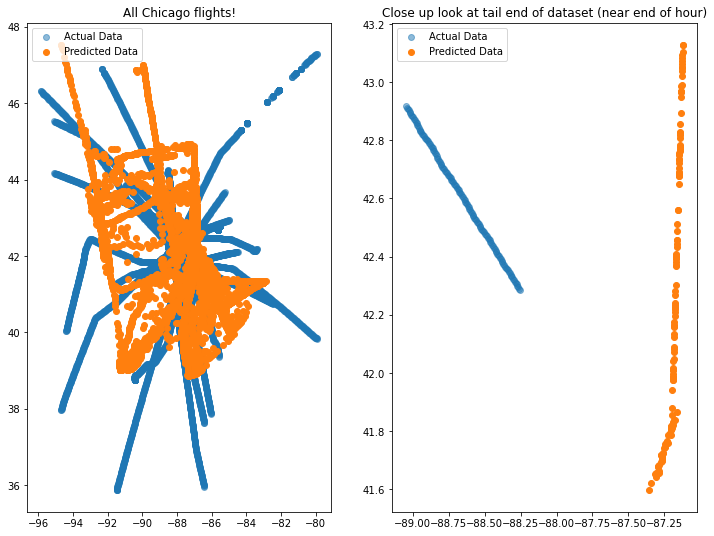

In [40]:
#PLotting the predictions against the actual flight data...

f, ax = plt.subplots(1,2, figsize=(12, 9))
ax[0].scatter(a_lat,a_lon, label='Actual Data', alpha= .5)#actual data
ax[0].legend(loc='upper left')
ax[0].scatter(p_lat,p_lon, label='Predicted Data')
ax[0].legend(loc='upper left')
ax[0].set_title('All Chicago flights!')

#WILL BE DIFFICULT TO SEPERATE predictions based on flight path, since i removed the icao24 variable...
ax[1].scatter(a_lat[10519:],a_lon[10519:], label='Actual Data', alpha= .5)#actual data
ax[1].legend(loc='upper left')
ax[1].scatter(p_lat[10519:],p_lon[10519:], label='Predicted Data') #appears i have no predicted data results...(probably becasue my loss was nan it never actually trained my lstm)
ax[1].legend(loc='upper left')
ax[1].set_title('Close up look at tail end of dataset (near end of hour)')
#data_predict

#wow actually got it to predict values!!!

### RMSE error measure

In [41]:
mse_lat = sklearn.metrics.mean_squared_error(a_lat, p_lat)
rmse_lat = math.sqrt(mse_lat)
mse_lon = sklearn.metrics.mean_squared_error(a_lon, p_lon)
rmse_lon = math.sqrt(mse_lon)

#error based on all of the data (training and test)
print("lat error:", rmse_lat, "lon error:", rmse_lon)

#DIFFICULT to calculate test LMSE, since the test and train data were seperate based on time threshold and not index...
# mse_lat_test = sklearn.metrics.mean_squared_error(a_lat[200:], p_lat[200:])
# rmse_lat_test = math.sqrt(mse_lat_test)
# mse_lon_test = sklearn.metrics.mean_squared_error(a_lon[200:], p_lon[200:])
# rmse_lon_test = math.sqrt(mse_lon_test)

# #Notices the error is larger when looking at only the test data. RMSE is measured in degrees 
# print("lat error:", rmse_lat_test, "lon error:", rmse_lon_test)

#what does this mean in terms of meters or another unit of measure? 
    #converting degrees to meters is a problem, and depends on where in the globe the degree is... 

lat error: 1.6051054680417725 lon error: 1.029414769176298


In [196]:
len(a_lat)

10651